## JAX & Flax LSTM 
Click the image below to read the post online.

<a target="_blank" href="https://www.machinelearningnuggets.com/jax-flax-lstm"><img src="https://digitalpress.fra1.cdn.digitaloceanspaces.com/mhujhsj/2022/07/logo.png" alt="Open in ML Nuggets"></a>

In [1]:
# pip install -U jax jaxlib flax

In [2]:
import os
# Obtain from https://www.kaggle.com/username/account
os.environ["KAGGLE_USERNAME"]="KAGGLE_USERNAME"
os.environ["KAGGLE_KEY"]="KAGGLE_KEY"

In [3]:
# pip install kaggle
import kaggle

In [4]:
!kaggle datasets download lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import zipfile
with zipfile.ZipFile('imdb-dataset-of-50k-movie-reviews.zip', 'r') as zip_ref:
    zip_ref.extractall('imdb-dataset-of-50k-movie-reviews')

In [6]:
import numpy as np 
import pandas as pd 
from numpy import array
import tensorflow as tf
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv("imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")


In [8]:
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [9]:
# df = df.sample(10000)

In [10]:
# pip install nltk

In [11]:
# pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
def remove_stop_words(review):
    review_minus_sw = []
    stop_words = stopwords.words('english')
    review = review.split()
    cleaned_review = [review_minus_sw.append(word) for word in review if word not in stop_words]            
    cleaned_review = ' '.join(review_minus_sw)
    return cleaned_review       

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/derrickmwiti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
df['review'] = df['review'].apply(remove_stop_words)
labelencoder = LabelEncoder()
df = df.assign(sentiment = labelencoder.fit_transform(df["sentiment"]))

In [13]:
df.head()

,review,sentiment
0,One reviewers mentioned watching 1 Oz episode ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically there's family little boy (Jake) thi...,0
4,"Petter Mattei's ""Love Time Money"" visually stu...",1


In [14]:
from sklearn.model_selection import train_test_split
df = df.drop_duplicates()
docs = df['review']
labels = array(df['sentiment'])
X_train, X_test , y_train, y_test = train_test_split(docs, labels , test_size = 0.20, random_state=0)

In [15]:
import tensorflow as tf
max_features = 10000  # Maximum vocab size.
batch_size = 128
max_len = 50 # Sequence length to pad the outputs to.
vectorize_layer = tf.keras.layers.TextVectorization(standardize='lower_and_strip_punctuation',max_tokens=max_features,
                                                    output_mode='int',output_sequence_length=max_len)
vectorize_layer.adapt(X_train)

Metal device set to: Apple M1


2022-08-20 09:50:58.244263: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [16]:
# vectorize_layer.get_vocabulary()

In [17]:
X_train_padded =  vectorize_layer(X_train)
X_test_padded =  vectorize_layer(X_test)

In [18]:
X_test_padded

<tf.Tensor: shape=(9917, 50), dtype=int64, numpy=
array([[1781,    2, 9062, ..., 4731, 3685,  123],
       [  10, 7331,  860, ..., 3819,    1, 1311],
       [ 108, 2906, 5709, ...,  539, 4384,  943],
       ...,
       [ 169,  104, 1132, ...,    1,    1, 3288],
       [  10,  159, 6590, ...,   10, 4616,    1],
       [ 273,  285,    6, ..., 2539,   53,   12]])>

In [19]:
X_train_padded

<tf.Tensor: shape=(39664, 50), dtype=int64, numpy=
array([[   1,    1,   48, ...,   71,    5, 9431],
       [   2,   46, 1269, ...,    0,    0,    0],
       [  84,  784,   38, ..., 3175,    1,    1],
       ...,
       [   2,  310,  328, ...,    4,  765,   76],
       [   2,  695, 1704, ..., 2211,    1, 6213],
       [   1,  241, 3061, ..., 3682,    1,  711]])>

In [20]:
training_data = tf.data.Dataset.from_tensor_slices((X_train_padded, y_train))
validation_data = tf.data.Dataset.from_tensor_slices((X_test_padded, y_test))
training_data = training_data.batch(batch_size)
validation_data = validation_data.batch(batch_size)

In [21]:
len(training_data)

310

In [22]:
# pip install tensorflow_datasets

In [23]:
# pip install tensorflow_datasets
import tensorflow_datasets as tfds
def get_train_batches():
  ds = training_data.prefetch(1)
  ds = ds.shuffle(3, reshuffle_each_iteration=True)
  # tfds.dataset_as_numpy converts the tf.data.Dataset into an iterable of NumPy arrays
  return tfds.as_numpy(ds)

In [24]:
for text, labels in get_train_batches():
  print(text.shape, labels.shape)
  break

(128, 50) (128,)


In [25]:
import jax

In [26]:
from flax import linen as nn

class LSTMModel(nn.Module):
    def setup(self):
        self.embedding = nn.Embed(max_features, max_len)
        lstm_layer = nn.scan(nn.OptimizedLSTMCell,
                               variable_broadcast="params",
                               split_rngs={"params": False},
                               in_axes=1, 
                               out_axes=1,
                               length=max_len,
                               reverse=False)
        self.lstm1 = lstm_layer()
        self.dense1 = nn.Dense(256)
        self.lstm2 = lstm_layer()
        self.dense2 = nn.Dense(128)
        self.lstm3 = lstm_layer()
        self.dense3 = nn.Dense(64)
        self.dense4 = nn.Dense(2)
        
    @nn.remat    
    def __call__(self, x_batch):
        x = self.embedding(x_batch)
        
        carry, hidden = nn.OptimizedLSTMCell.initialize_carry(jax.random.PRNGKey(0), batch_dims=(len(x_batch),), size=128)
        (carry, hidden), x = self.lstm1((carry, hidden), x)
        
        x = self.dense1(x)
        x = nn.relu(x)
        
        carry, hidden = nn.OptimizedLSTMCell.initialize_carry(jax.random.PRNGKey(0), batch_dims=(len(x_batch),), size=64)
        (carry, hidden), x = self.lstm2((carry, hidden), x)
        
        x = self.dense2(x)
        x = nn.relu(x)
        
        carry, hidden = nn.OptimizedLSTMCell.initialize_carry(jax.random.PRNGKey(0), batch_dims=(len(x_batch),), size=32)
        (carry, hidden), x = self.lstm3((carry, hidden), x)
        
       
        x = self.dense3(x)
        x = nn.relu(x)
        x = self.dense4(x[:, -1])
        return nn.log_softmax(x)

In [27]:
import optax
import jax.numpy as jnp
def compute_metrics(logits, labels):
  loss = jnp.mean(optax.softmax_cross_entropy(logits, jax.nn.one_hot(labels, num_classes=2)))
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy
  }
  return metrics

In [28]:
from flax.training import train_state

def create_train_state(rng):
  """Creates initial `TrainState`."""
  model = LSTMModel()
  params = model.init(rng, jnp.array(X_train_padded[0]))['params']
  tx = optax.adam(0.001,0.9,0.999,1e-07)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

In [29]:
@jax.jit
def train_step(state, text, labels):
  def loss_fn(params):
    logits = LSTMModel().apply({'params': params}, text)
    loss = jnp.mean(optax.softmax_cross_entropy(
        logits=logits, 
        labels=jax.nn.one_hot(labels, num_classes=2)))
    return loss, logits
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(logits, labels)
  return state, metrics

In [30]:
@jax.jit
def eval_step(state, text, labels):
    logits = LSTMModel().apply({'params': state.params}, text)
    return compute_metrics(logits=logits, labels=labels)

In [31]:
def train_one_epoch(state):
    """Train for 1 epoch on the training set."""
    batch_metrics = []
    for text, labels in get_train_batches():
        state, metrics = train_step(state, text, labels)
        batch_metrics.append(metrics)

    batch_metrics_np = jax.device_get(batch_metrics)  
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }

    return state, epoch_metrics_np

In [32]:
def evaluate_model(state, text, test_lbls):
    """Evaluate on the validation set."""
    metrics = eval_step(state, text, test_lbls)
    metrics = jax.device_get(metrics) 
    metrics = jax.tree_map(lambda x: x.item(), metrics)  
    return metrics


In [34]:
rng = jax.random.PRNGKey(0)
rng, input_rng, init_rng = jax.random.split(rng,num=3)

seed = 0 

state = create_train_state(init_rng)
del init_rng  # Must not be used anymore.

num_epochs = 30
(text, test_labels) = next(iter(validation_data))
text = jnp.array(text)
test_labels = jnp.array(test_labels)
training_loss = []
training_accuracy = []
testing_loss = []
testing_accuracy = []

def train_model():
    for epoch in range(1, num_epochs + 1):
        train_state, train_metrics = train_one_epoch(state)
        training_loss.append(train_metrics['loss'])
        training_accuracy.append(train_metrics['accuracy'])
        test_metrics = evaluate_model(train_state, text, test_labels)
        testing_loss.append(test_metrics['loss'])
        testing_accuracy.append(test_metrics['accuracy'])
        print(f"Epoch: {epoch}, train loss: {train_metrics['loss']}, train accuracy: {train_metrics['accuracy'] * 100}, test loss: {test_metrics['loss']}, test accuracy: {test_metrics['accuracy'] * 100}")
    return train_state
            

In [35]:
trained_model_state = train_model()

Epoch: 1, train loss: 0.5181223154067993, train accuracy: 72.96910881996155, test loss: 0.3984663784503937, test accuracy: 81.25
Epoch: 2, train loss: 0.5146048069000244, train accuracy: 73.40149879455566, test loss: 0.3701508045196533, test accuracy: 82.03125
Epoch: 3, train loss: 0.5193819403648376, train accuracy: 72.83770442008972, test loss: 0.40014731884002686, test accuracy: 82.03125
Epoch: 4, train loss: 0.5183917284011841, train accuracy: 72.53960371017456, test loss: 0.37042367458343506, test accuracy: 82.8125
Epoch: 5, train loss: 0.5249800086021423, train accuracy: 72.58496880531311, test loss: 0.3643062710762024, test accuracy: 83.59375
Epoch: 6, train loss: 0.5190929174423218, train accuracy: 73.35829138755798, test loss: 0.3652305006980896, test accuracy: 82.03125
Epoch: 7, train loss: 0.5145283937454224, train accuracy: 73.30069541931152, test loss: 0.36744457483291626, test accuracy: 85.15625
Epoch: 8, train loss: 0.5215045809745789, train accuracy: 72.81106114387512, 

In [36]:
from flax.training import checkpoints

In [37]:
checkpoints.save_checkpoint(ckpt_dir='lstm_model_checkpoint/',  
                            target=trained_model_state, 
                            step=100, 
                            prefix='lstm_model',  
                            overwrite=False  
                           )

'lstm_model_checkpoint/lstm_model100'

In [38]:
loaded_model = checkpoints.restore_checkpoint(
                                             ckpt_dir='lstm_model_checkpoint/',   
                                             target=state,  
                                             prefix='lstm_model'  
                                            )

In [42]:
evaluate_model(loaded_model, text, test_labels)

{'accuracy': 0.8125, 'loss': 0.39753445982933044}

In [39]:
loaded_model

TrainState(step=array(310, dtype=int32), apply_fn=<bound method Module.apply of LSTMModel()>, params=FrozenDict({
    dense1: {
        bias: array([-0.0214396 , -0.0199079 , -0.00666685, -0.02555098, -0.01636086,
               -0.00373238, -0.01601895, -0.03622564, -0.00627432, -0.00152315,
               -0.01652798, -0.02598455, -0.01753522, -0.0409378 ,  0.00886804,
               -0.02373846, -0.01436223,  0.00646091, -0.01227203, -0.03024597,
                0.00809508,  0.00089901, -0.02624042, -0.0221938 , -0.02084175,
               -0.0364866 , -0.00883595, -0.03259901, -0.01131388, -0.02173724,
               -0.01577202, -0.01157229, -0.00478712, -0.01239445, -0.01824646,
                0.00105295, -0.00373597, -0.02441801, -0.01538182,  0.00458976,
               -0.01445186, -0.00775169, -0.00359485, -0.03655976, -0.04119535,
                0.00166789, -0.01585965, -0.0172938 , -0.00962321, -0.01858063,
               -0.00895448, -0.01345404, -0.0391895 , -0.02907144,

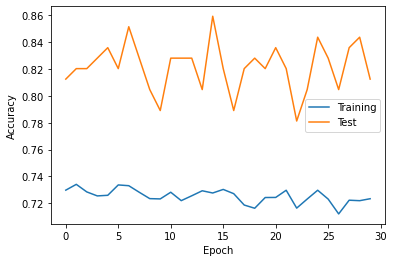

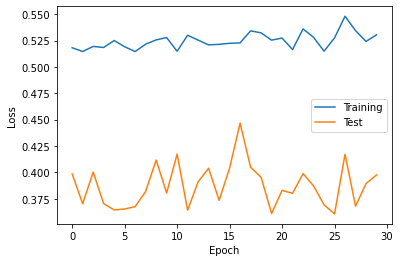

In [40]:
plt.plot(training_accuracy, label="Training")
plt.plot(testing_accuracy, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


plt.plot(training_loss, label="Training")
plt.plot(testing_loss, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Where to go from here
Follow us on [LinkedIn](https://www.linkedin.com/company/mlnuggets), [Twitter](https://twitter.com/ml_nuggets), [GitHub](https://github.com/mlnuggets) and subscribe to our [blog](https://www.machinelearningnuggets.com/#/portal) so that you don't miss a new issue.